# 📊 Stock Portfolio Analyzer and Optimizer

This notebook demonstrates a complete pipeline for stock portfolio optimization using:
- Yahoo Finance API via `yfinance`
- Portfolio metrics: Sharpe Ratio, Volatility, Value-at-Risk (VaR)
- Mean-Variance Optimization (Markowitz Model)
- Efficient Frontier via Monte Carlo Simulation
- Visualization using `matplotlib`

**Date:** April 2025

In [1]:
%pip install --user yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Step 1: Install and Import Required Libraries
%pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.style.use('seaborn-v0_8')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
start_date = '2020-01-01'
end_date = '2024-12-31'

# Download and inspect structure
data = yf.download(tickers, start=start_date, end=end_date)
print(data.columns)  # <- helps you debug

# Extract close prices (since 'Adj Close' is not present)
close_prices = data.xs('Close', axis=1, level=0)
print(close_prices.tail())

#close_prices.to_csv("closing_prices_2020_2024.csv") -- to show all data



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'AMZN'),
            ( 'Close', 'GOOG'),
            ( 'Close', 'MSFT'),
            (  'High', 'AAPL'),
            (  'High', 'AMZN'),
            (  'High', 'GOOG'),
            (  'High', 'MSFT'),
            (   'Low', 'AAPL'),
            (   'Low', 'AMZN'),
            (   'Low', 'GOOG'),
            (   'Low', 'MSFT'),
            (  'Open', 'AAPL'),
            (  'Open', 'AMZN'),
            (  'Open', 'GOOG'),
            (  'Open', 'MSFT'),
            ('Volume', 'AAPL'),
            ('Volume', 'AMZN'),
            ('Volume', 'GOOG'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])
Ticker            AAPL        AMZN        GOOG        MSFT
Date                                                      
2024-12-23  254.655716  225.059998  195.766968  433.583038
2024-12-24  257.578674  229.050003  197.345184  437.647369
2024-12-26  258.396667  227.050003  196.875717  436.432068
2024-12-27  254.974930  22

In [5]:
# Step 3: Calculate Daily Returns
returns = data.pct_change().dropna()
returns.tail()

Price          Close                                    High            \
Ticker          AAPL      AMZN      GOOG      MSFT      AAPL      AMZN   
Date                                                                     
2024-12-23  0.003065  0.000622  0.015703 -0.003092  0.002549  0.002962   
2024-12-24  0.011478  0.017729  0.008062  0.009374  0.010014  0.009961   
2024-12-26  0.003176 -0.008732 -0.002379 -0.002777  0.007320 -0.002793   
2024-12-27 -0.013242 -0.014534 -0.015525 -0.017302 -0.005383 -0.010810   
2024-12-30 -0.013263 -0.010950 -0.006957 -0.013240 -0.020101 -0.013405   

Price                                Low                                \
Ticker          GOOG      MSFT      AAPL      AMZN      GOOG      MSFT   
Date                                                                     
2024-12-23  0.012131 -0.013724  0.031584  0.023636  0.028223  0.009799   
2024-12-24  0.006005  0.004456  0.007260  0.009960  0.018619  0.003142   
2024-12-26  0.002479  0.003048  0.009166  0.002388  0.003443  0.005620   
2024-12-27 -0.006863 -0.012972 -0.017739 -0.025456 -0.019901 -0.023544   
2024-12-30 -0.015346 -0.017623 -0.009128 -0.011182 -0.008397 -0.010437   

Price           Open                                  Volume            \
Ticker          AAPL      AMZN      GOOG      MSFT      AAPL      AMZN   
Date                                                                     
2024-12-23  0.027133  0.023517  0.037538  0.008381 -0.722982 -0.682032   
2024-12-24  0.002826  0.008577  0.011029 -0.004786 -0.431342 -0.465354   
2024-12-26  0.010568  0.006874  0.002906  0.010192  0.172260  0.075909   
2024-12-27 -0.001394 -0.012691 -0.001372 -0.010203  0.555059  0.694904   
2024-12-30 -0.021720 -0.024557 -0.028528 -0.019650 -0.160495  0.034863   

Price                           
Ticker          GOOG      MSFT  
Date                            
2024-12-23 -0.663813 -0.701970  
2024-12-24 -0.553042 -0.625924  
2024-12-26  0.161253  0.143723  
2024-12-27  0.858015  1.211040  
2024-12-30 -0.169026 -0.273710

In [6]:
# Step 4: Define Portfolio Metrics
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.sum(weights * mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe = ret / vol
    return ret, vol, sharpe

def neg_sharpe(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

def check_sum(weights):
    return np.sum(weights) - 1

In [7]:
# Step 5: Optimize Portfolio for Max Sharpe Ratio
# Use only 'Close' prices for optimization
mean_returns_close = returns['Close'].mean()
cov_matrix_close = returns['Close'].cov()
num_assets = len(tickers)
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = num_assets * [1. / num_assets]

constraints = ({'type': 'eq', 'fun': check_sum})

opt_result = minimize(neg_sharpe, initial_weights, args=(mean_returns_close, cov_matrix_close),
                     method='SLSQP', bounds=bounds, constraints=constraints)

opt_weights = opt_result.x
opt_return, opt_volatility, opt_sharpe = portfolio_performance(opt_weights, mean_returns_close, cov_matrix_close)

for i, ticker in enumerate(tickers):
    print(f"{ticker}: {opt_weights[i]*100:.2f}%")
print(f"\nExpected Return: {opt_return*100:.2f}%")
print(f"Volatility: {opt_volatility*100:.2f}%")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

AAPL: 64.56%
MSFT: 0.00%
GOOG: 27.11%
AMZN: 8.33%

Expected Return: 28.51%
Volatility: 29.08%
Sharpe Ratio: 0.98


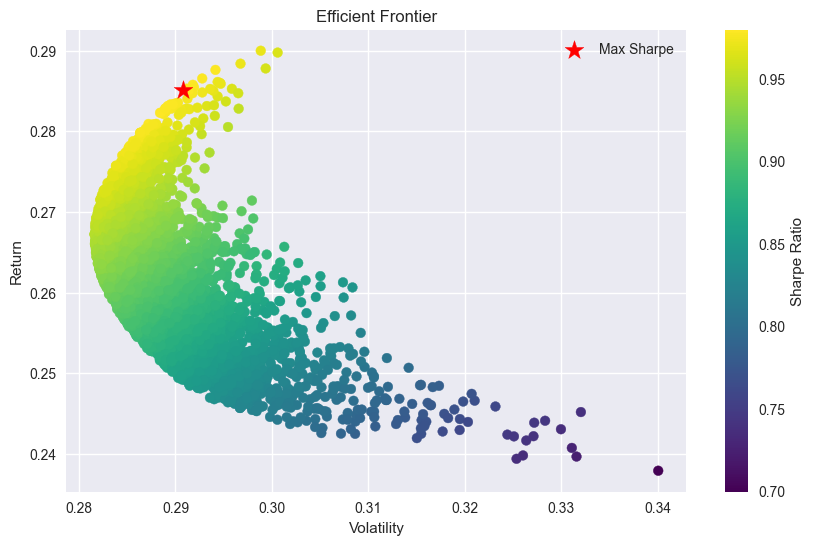

In [8]:
# Step 6: Monte Carlo Simulation for Efficient Frontier
num_portfolios = 5000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    ret, vol, sharpe = portfolio_performance(weights, mean_returns_close, cov_matrix_close)
    results[0,i] = ret
    results[1,i] = vol
    results[2,i] = sharpe

# Plot Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_volatility, opt_return, c='red', marker='*', s=200, label='Max Sharpe')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

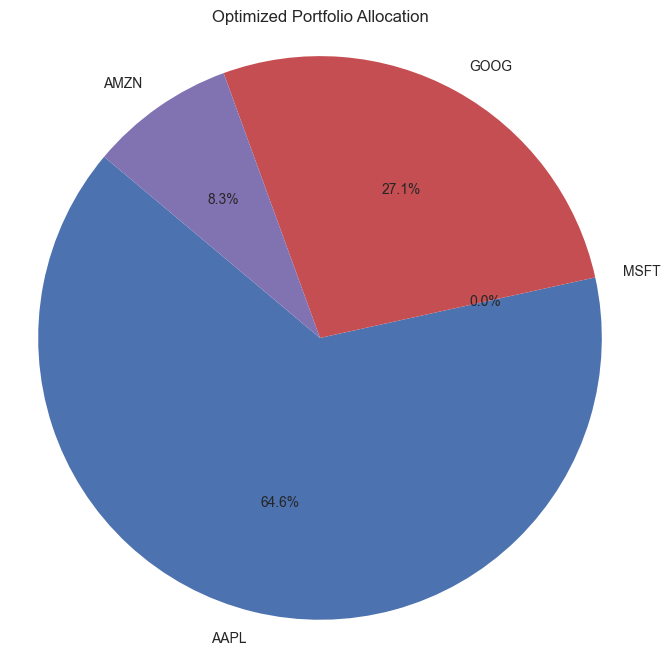

In [9]:
# Step 7: Pie Chart of Optimal Allocation
plt.figure(figsize=(8, 8))
plt.pie(opt_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimized Portfolio Allocation')
plt.axis('equal')
plt.show()